In [4]:
import root_pandas as rp
import pandas as pd
import ROOT
import numpy as np
import matplotlib.pyplot as plt

f = '~/data/thesis_data/mc_with_reco_cm.root'
rf = ROOT.TFile(f)
rf.ls() #list tree names

TFile**		/home/jeff/data/thesis_data/mc_with_reco_cm.root	
 TFile*		/home/jeff/data/thesis_data/mc_with_reco_cm.root	
  KEY: TTree	truth_mu_cms;1	
  KEY: TTree	truth_mu_lab;1	
  KEY: TTree	truth_Dst_lab;1	
  KEY: TTree	truthD_lab;1	
  KEY: TTree	truth_e_CMS;1	
  KEY: TTree	mu_lab;1	
  KEY: TTree	e_lab;1	
  KEY: TTree	truth_e_lab;1	
  KEY: TTree	truth_K_lab;1	
  KEY: TTree	truth_pi0_lab;1	
  KEY: TTree	truth_pi_lab;1	
  KEY: TTree	B_lab;1	
  KEY: TTree	truthB_lab;1	
  KEY: TTree	truth_lepton_cms;1	truth_lepton_cms
  KEY: TTree	truth_lepton_lab;1	truth_lepton_lab
  KEY: TTree	lepton_lab;1	lepton_lab
  KEY: TTree	lepton;1	lepton


## Adding boosting to CM and adding CM branches

In [5]:
gamma = (8+3.5)/10.58 #detector gamma given by (E_LER + E_HER)/E_upsilon(4s)
beta = np.sqrt((gamma**2-1)/gamma**2)
boost = beta*gamma

/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


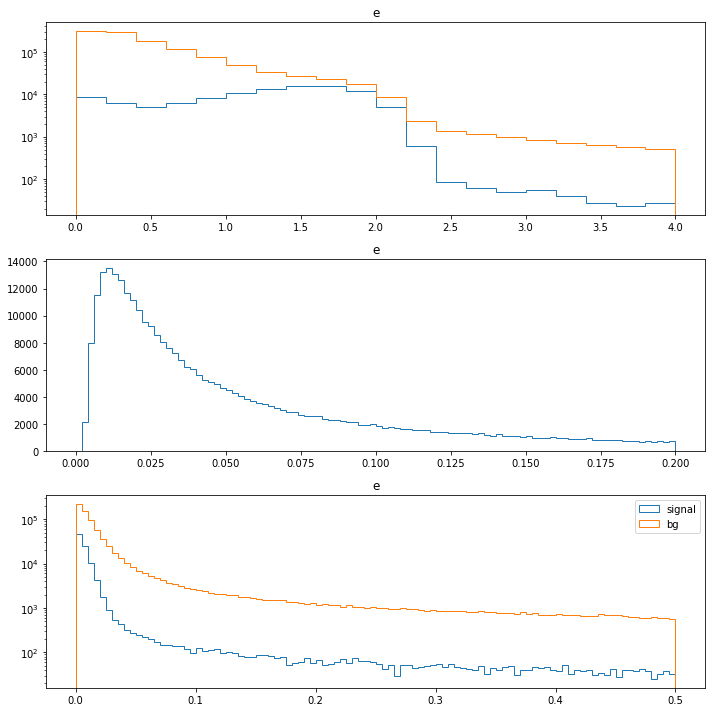

In [6]:
e = rp.read_root(f, key='e_lab') #Use only electrons, muons produce same charges and momenta
#mu = rp.read_root(f, key = 'mu_lab')
def add_cm_branches(df):
    E = np.sqrt(df['p']**2+df['M']**2) #get energy of lepton tracks
    df['E'] = E #add energy branch
    gamma = (8+3.5)/10.58 #detector gamma given by (E_LER + E_HER)/E_upsilon(4s)
    beta = np.sqrt((gamma**2-1)/gamma**2)
    boost = beta*gamma
    df['pz_cm']=-beta*gamma*df['E']+gamma*df['pz'] #From lorentz transformation
    df['p_cm'] = np.sqrt((df['px'])**2+(df['py'])**2+(df['pz_cm'])**2) #Only z is boosted
    return df

e = add_cm_branches(e)
sig = e.loc[e['isSignal']==1]
bg = e.loc[e['isSignal']==0]
#mu = add_cm_branches(mu)

#cm_pz = []
#to test performance of hand code vs ROOT TLorentzVector
#for px, py, pz, E in zip(e['px'].to_numpy(), e['py'].to_numpy(), e['pz'].to_numpy(), e['E'].to_numpy()):
#    v = ROOT.TLorentzVector()
#    v.SetPxPyPzE(px, py, pz, E)
#    v.Boost(0,0,-beta)
#    cm_pz.append(v.Pz())
#e['ROOT_pz_cm'] = cm_pz
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.hist(sig['p_cm'], histtype = 'step', bins = 20, range = (0,4), label = 'signal')
plt.hist(bg['p_cm'], histtype = 'step', bins = 20, range = (0,4), label = 'bg')
plt.yscale("log")
plt.title('e')
plt.subplot(3,1,2)
#plt.hist(np.abs(e['z'])/(boost*2.99792e10)*1e12, histtype = 'step', bins = 100, range = (0,20000), label = 't')
index = e.loc[e['z']<1.8].index.to_numpy()
plt.hist(e['z_uncertainty'][index]/e['z'][index], histtype = 'step', bins = 100, label = 'z_uncertainty/z', range = (0,0.2))
plt.title('e')
plt.subplot(3,1,3)
plt.hist(sig['dr'], histtype = 'step', bins = 100, range = (0,0.5), label = 'signal')
plt.hist(bg['dr'], histtype = 'step', bins = 100, range = (0,0.5), label = 'bg')
plt.title('e')
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

#### Figure out p_cm that maximizes sig/bg eff weighted by number of remaining sig events

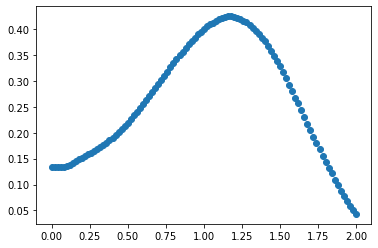

In [7]:
#e = e.loc[(e['dr']<0.03)]
FOM = []
for min_p in np.linspace(0,2,101):
    sig_eff = len(sig.loc[(e['dr']<0.05) & (sig['p_cm']<2.3) & (sig['p_cm']>min_p)])/len(sig)
    bg_eff = len(bg.loc[(e['dr']<0.05) & (bg['p_cm']<2.3) & (bg['p_cm']>min_p)])/len(bg)
    FOM.append(sig_eff**2/bg_eff*len(sig)/1e6) #Maximized at p_cm = 1.16
plt.plot(np.linspace(0,2,101),FOM,'o')

#### Determining indices of 2 highest momentum events

(100.0, 50000.0)

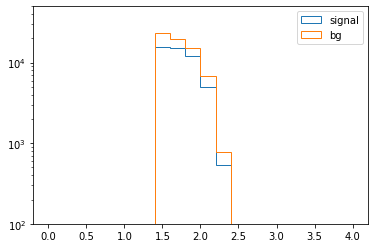

In [8]:
e = e.loc[(e['dr']<0.2) & (e['p_cm']<2.4) & (e['p_cm']>1.4)] #numbers from me
'''Plot signal and bg for cm_mom after dr cuts'''
plt.hist(e.loc[e['isSignal']==1]['p_cm'], histtype = 'step', bins = 20, range = (0,4), label = 'signal')
plt.hist(e.loc[e['isSignal']==0]['p_cm'], histtype = 'step', bins = 20, range = (0,4), label = 'bg')
plt.legend()
plt.yscale("log")
plt.ylim(1e2,5e4)

In [23]:
#e = e.loc[(e['p_cm']<2.3) & ((e['z_uncertainty']/e['z'])<0.2) & (e['z']<1.8)]
#e = e.loc[(e['dr']<0.2) & (e['p_cm']<2.3)]
e = e.loc[(e['dr']<0.2) & (e['p_cm']<2.4) & (e['p_cm']>1.4)] # numbers from Abe to test
e.index = [i for i in range(0,len(e))]
index = e.groupby(['__event__'])['p_cm'].nlargest(2)
indices = []
for i in range(0,len(index)):
    indices.append(index.index[i][1])
indices = np.array(indices)
indices = np.sort(indices)

#### Loading B file to compare event level SF and OF with truth

In [24]:
B = rp.read_root('~/workspace/thesis_data/mc_with_deltaT.root', key='truthB_lab')
B = B.loc[B.index.duplicated()==False]
B.index = [i for i in range(0,len(B))]

#### Comparing SF and OF between truth B's and reconstructed lepton tracks before further cuts

In [25]:
df_red = e.iloc[indices]
table = df_red.pivot_table(index=['__event__'], aggfunc='size') #lists number of elements in each event
df_red = df_red.loc[df_red['__event__'].isin(table.loc[table.values == 2].index.to_numpy())] #only keep events where there are two elements
df_red.index = [i for i in range(0,len(df_red))]
odd_index = [i for i in range(0,len(df_red)) if i%2 == 1]
## Code below is quick way to deterine OF and SF exploiting .diff() and odd indices
df_red['OF']=0
df_red['SF']=0
df_red['SF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]==0].index.to_numpy()]=1
df_red['SF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]==0].index.to_numpy()-1]=1
df_red['OF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]!=0].index.to_numpy()]=1
df_red['OF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]!=0].index.to_numpy()-1]=1
##
df_red = df_red.loc[df_red['__event__'].isin(B['__event__'].unique())]
B = B.loc[B['__event__'].isin(df_red['__event__'].unique())]
df_red.index = [i for i in range(0,len(df_red))]

#For small file
B.index = [i for i in range(0,len(B))]
B['OF'] = 0
B['SF'] = 0
odd_index = [i for i in range(0,len(df_red)) if i%2 == 1]
B['SF'][B.loc[odd_index].loc[B['mcPDG'].diff()[odd_index]==0].index.to_numpy()]=1
B['SF'][B.loc[odd_index].loc[B['mcPDG'].diff()[odd_index]==0].index.to_numpy()-1]=1
B['OF'][B.loc[odd_index].loc[B['mcPDG'].diff()[odd_index]!=0].index.to_numpy()]=1
B['OF'][B.loc[odd_index].loc[B['mcPDG'].diff()[odd_index]!=0].index.to_numpy()-1]=1
df_red['B_OF']=B['OF']
df_red['B_SF']=B['SF']
#End for small file

#print(df_red[['__event__','charge','OF','SF','B_OF','B_SF']])
print(len(df_red.loc[df_red['OF']!=df_red['B_OF']])/len(df_red)) #shows mistagging fraction

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by Inte

0.0918631929867885


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Determining z resolution

In [26]:
df_red['B_deltaZ'] = B['deltaZ']
df_red['B_deltaT'] = B['deltaZ']/(boost*2.99792e10)*1e12
#compute delta z but only for odd indices beacuse it's faster
deltaZ = [np.abs(df_red['z'].loc[df_red['__event__']==event].diff().iloc[1]) for event in df_red['__event__'].unique()]
deltaZ_err = [np.sqrt(df_red.loc[df_red['__event__']==event]['z_uncertainty'].iloc[0]**2+df_red.loc[df_red['__event__']==event]['z_uncertainty'].iloc[1]**2) for event in df_red['__event__'].unique()] 
odd_index = np.array([i for i in range(0,len(df_red)) if i%2 == 1])
df_red['deltaZ'] = 0
df_red['deltaZ_err'] = 0
df_red['deltaZ'][odd_index] = deltaZ
df_red['deltaZ'][odd_index-1] = deltaZ
df_red['deltaZ_err'][odd_index] = deltaZ_err
df_red['deltaZ_err'][odd_index-1] = deltaZ_err
df_red['deltaT'] = df_red['deltaZ']/(boost*2.99792e10)*1e12
df_red['deltaT_err'] = df_red['deltaZ_err']/(boost*2.99792e10)*1e12


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by Inte

0.08366077275703995 0.3770835905667366


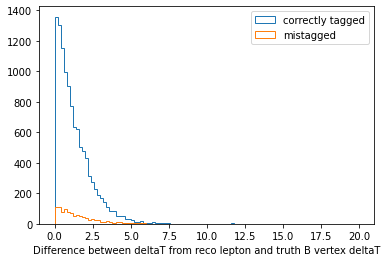

In [40]:
#df_cut = df_red.loc[np.abs(df_red['deltaT']-df_red['B_deltaT'])<1]
#df_cut = df_red.loc[(df_red['deltaT_err']<0.25) & (df_red['deltaT']<20)]
#df_cut = df_red.loc[(df_red['deltaT']<25) & (df_red['deltaT_err']<1)]
df_cut = df_red.loc[(df_red['deltaT_err']<0.4)] #temporary for now
#df_cut = df_red
print(len(df_cut.loc[df_cut['OF']!=df_cut['B_OF']])/len(df_cut), len(df_cut)/len(df_red))
signal_indices = df_cut.loc[(df_cut['deltaZ'].duplicated() == False) & (df_cut['OF']==df_cut['B_OF'])].index.to_numpy()
bg_indices = df_cut.loc[(df_cut['deltaZ'].duplicated() == False) & (df_cut['OF']!=df_cut['B_OF'])].index.to_numpy()
plt.hist(np.abs(df_cut['deltaT'][signal_indices]-df_cut['B_deltaT'][signal_indices]),bins = 100, histtype = 'step', label = 'correctly tagged', range = (0,20))
plt.hist(np.abs(df_cut['deltaT'][bg_indices]-df_cut['B_deltaT'][bg_indices]),bins = 100, histtype = 'step', label = 'mistagged', range = (0,20))
plt.xlabel('Difference between deltaT from reco lepton and truth B vertex deltaT')
#plt.yscale("log")
plt.legend()

Text(0.5, 0, 'unique event')

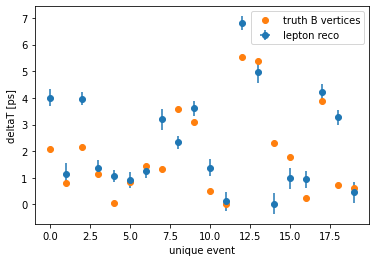

In [41]:
df_cut = df_cut.loc[df_cut['__event__'].duplicated()==False]
plt.errorbar([i for i in range(0,20)], df_cut.tail(20)['deltaT'], df_cut.tail(20)['deltaT_err'], [0 for i in range(20)], 'o', label = 'lepton reco')
plt.plot([i for i in range(0,20)], df_cut.tail(20)['B_deltaT'], 'o', label = 'truth B vertices')
plt.legend()
plt.ylabel('deltaT [ps]')
plt.xlabel('unique event')

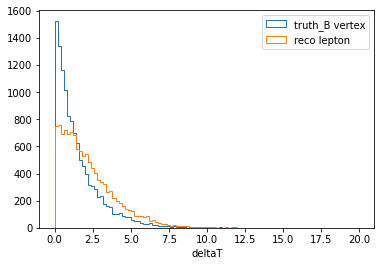

,deltaT,deltaT_err
0,0.607500,0.292133
8,1.706296,0.393819
14,1.011177,0.306002
20,1.282693,0.260836
22,2.407149,0.361436
...,...,...
64758,0.978145,0.380058
64766,0.941310,0.311592
64768,4.213260,0.310462
64772,3.266001,0.282385


In [42]:
indices = df_cut.loc[(df_cut['deltaZ'].duplicated() == False)].index.to_numpy()
plt.hist(df_cut['B_deltaT'][indices], bins = 100, histtype = 'step', label = 'truth_B vertex', range = (0,20))
plt.hist(df_cut['deltaT'][indices], bins = 100, histtype = 'step', label = 'reco lepton', range = (0,20))
plt.legend()
plt.xlabel('deltaT')
plt.show()
df_cut[['deltaT','deltaT_err']]

#### Plotting asymmetry

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in long_scalars


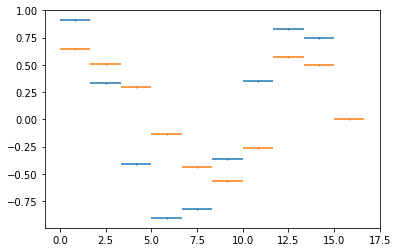

In [43]:
'''
def compute_asymmetry(data, col, prefix = ''): #enter 'B_' as prefix for truth plotting
    data['bin_num'] = 0                                                                                                                                           
    data['bin_num'][data.loc[(data[col]>=0.5) & (data[col]< 1)].index.to_numpy()]=1 #Bin_Num according to Go's convention                               
    for i in range(2, 8):
        data['bin_num'][data.loc[(data[col]>=i-1) & (data[col]< i)].index.to_numpy()]=i
    data['bin_num'][data.loc[(data[col]>=7) & (data[col]< 9)].index.to_numpy()]=8
    data['bin_num'][data.loc[(data[col]>=9) & (data[col]< 13)].index.to_numpy()]=9
    data['bin_num'][data.loc[(data[col]>=13) & (data[col]< 20)].index.to_numpy()]=10
    data['asymmetry'] = 0
    asymmetry = []
    for i in range(0,11):
        asymmetry.append((data.loc[data['bin_num']==i][prefix+'OF'].sum()-data.loc[data['bin_num']==i][prefix+'SF'].sum())/(data.loc[data['bin_num']==i][prefix+'OF'].sum()+data.loc[data['bin_num']==i][prefix+'SF'].sum()))
        index = data.loc[data['bin_num'] == i].index.to_numpy()
        data['asymmetry'][index] = asymmetry[i]
    def make_plot(data):
        data_red = data.loc[data['bin_num'].duplicated() == False]
        data_red = data_red.sort_values(by = ['bin_num'])
        #print(data_red)
        data_red['x'] = np.array([0.25, 0.75, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 8, 11, 16.5])
        data_red['xerr'] = np.array([0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])
        plt.plot(data_red['x'], data_red['asymmetry'], 'o')
        plt.ylim(-1.1,1.1)
        #plt.show()
    make_plot(data)
    return asymmetry
'''
def plot(input_data, col = 'deltaT', prefix = '', bins = 30): #add 'B_' as prefix to plot truth qtys
    data = input_data.loc[(input_data[prefix+col]<np.min([input_data[col].max(), input_data['B_'+col].max()]))]
    #print(np.min([input_data[col].max(), input_data['B_'+col].max()]))
    #counts, bins = np.histogram(data[prefix+col], bins=bins)
    bins = np.linspace(0,20,bins)
    centers = []
    for j in range(0,len(bins)-1):
        centers.append((bins[j]+bins[j+1])/2)
    asymmetry = []
    for i in range(0,len(bins)-1):
        index = data.loc[(data[prefix+col]<=bins[i+1]) & (data[prefix+col]>bins[i])].index.to_numpy()
        asymmetry.append((data[prefix+'OF'][index].sum()-data[prefix+'SF'][index].sum())/(data[prefix+'OF'][index].sum()+data[prefix+'SF'][index].sum()))
    plt.errorbar(centers, asymmetry, [0 for i in range(0,len(asymmetry))], [(bins[1]-bins[0])/2 for i in range(0,len(asymmetry))], 'o', markersize = 1)
plot(df_red, prefix = 'B_', bins = 13)
plot(df_cut, bins = 13)
#counts_bg, bins_bg = np.histogram(bg_df[var], bins=30)
#centers_sig = []
#centers_bg = []
#for j in range(0,len(bins_sig)-1):
#    centers_sig.append((bins_sig[j]+bins_sig[j+1])/2)
#    centers_bg.append((bins_bg[j]+bins_bg[j+1])/2)
#plt.bar(centers_sig, counts_sig/len(signal_df), width = bins_sig[1]-bins_sig[0], alpha = 0.5, label = 'signal')
#plt.bar(centers_bg, counts_bg/len(bg_df), width = bins_bg[1]-bins_bg[0], alpha = 0.5, label = 'bg')

#data_test = df_cut
#data_B = df_red
#asymmetry = compute_asymmetry(data_test, 'deltaT', '')
#asymmetry = compute_asymmetry(data_B, 'B_deltaT', 'B_')
#plt.show()

In [ ]:
df_bad = df_cut.loc[(df_cut['deltaT'].duplicated()==False) & (np.abs(df_cut['deltaT']-df_cut['B_deltaT'])>1)]
df_good = df_cut.loc[(df_cut['deltaT'].duplicated()==False) & (np.abs(df_cut['deltaT']-df_cut['B_deltaT'])<1)]
i = 1
columns = [col for col in df_good.columns]
fig = plt.figure(figsize=(24,36))
for col in columns:
    try:
        plt.subplot(15,5,i)
        #mean = df_tag[col].mean()
        #std = df_tag[col].std()
        #min = df_tag[col].mean() - 5*df_tag[col].std()
        #max = df_tag[col].mean() + 5*df_tag[col].std()
        plt.hist(df_good[col], alpha = 0.5, bins = 60)#, range = (min,max))
        plt.hist(df_bad[col], alpha = 0.5, bins = 60)#, range = (min,max))
        plt.title(col)
        #plt.yscale("Log")
        i+=1
    except ValueError:
        pass
fig.tight_layout()
fig.show()

In [ ]:
plt.hist(df_good['pzErr'], bins = 50, histtype = 'step', range = (0,0.008))
plt.hist(df_bad['pzErr'], bins = 50, histtype = 'step', range = (0,0.008))

### Looking at discriminating variables between properly tagged and mistagged events

In [ ]:
df_tag = df_red.loc[df_red['OF']==df_red['B_OF']] #properly tagged events
df_mistag = df_red.loc[df_red['OF']!=df_red['B_OF']] #mistagged events
i = 1
columns = [col for col in df_tag.columns]
fig = plt.figure(figsize=(24,36))
for col in df_tag.columns:
    try:
        plt.subplot(15,5,i)
        mean = df_tag[col].mean()
        std = df_tag[col].std()
        min = df_tag[col].mean() - 5*df_tag[col].std()
        max = df_tag[col].mean() + 5*df_tag[col].std()
        plt.hist(df_tag[col], alpha = 0.5, bins = 60, range = (min,max))
        plt.hist(df_mistag[col], alpha = 0.5, bins = 60, range = (min,max))
        plt.title(col)
        plt.yscale("Log")
        i+=1
    except ValueError:
        pass
fig.tight_layout()
fig.show()


In [ ]:
def do_cuts(low_cut,high_cut):
    e = rp.read_root(f, key='e_lab') #Use only electrons, muons produce same charges and momenta
    E = np.sqrt(e['p']**2+e['M']**2) #get energy of lepton tracks
    e['E'] = E #add energy branch
    gamma = (8+3.5)/10.58 #detector gamma given by (E_LER + E_HER)/E_upsilon(4s)
    beta = np.sqrt((gamma**2-1)/gamma**2)
    boost = beta*gamma
    e['pz_cm']=-beta*gamma*e['E']+gamma*e['pz'] #From lorentz transformation
    e['p_cm'] = np.sqrt((e['px'])**2+(e['py'])**2+(e['pz_cm'])**2) #Only z is boosted
    e = e.loc[(e['p_cm']<high_cut) & (e['p_cm']>low_cut)]
    e.index = [i for i in range(0,len(e))]
    index = e.groupby(['__event__'])['p_cm'].nlargest(2)
    indices = []
    for i in range(0,len(index)):
        indices.append(index.index[i][1])
    indices = np.array(indices)
    indices = np.sort(indices)
    B = rp.read_root('~/workspace/thesis_data/mc_with_deltaT.root', key='truthB_lab')
    B = B.loc[B.index.duplicated()==False]
    B.index = [i for i in range(0,len(B))]
    df_red = e.iloc[indices]
    df_red.index = [i for i in range(0,len(df_red))]
    odd_index = [i for i in range(0,len(df_red)) if i%2 == 1]
    ## Code below is quick way to deterine OF and SF exploiting .diff() and odd indices
    df_red['OF']=0
    df_red['SF']=0
    df_red['SF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]==0].index.to_numpy()]=1
    df_red['SF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]==0].index.to_numpy()-1]=1
    df_red['OF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]!=0].index.to_numpy()]=1
    df_red['OF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]!=0].index.to_numpy()-1]=1
    ##
    df_red = df_red.loc[df_red['__event__'].isin(B['__event__'].unique())]
    B = B.loc[B['__event__'].isin(df_red['__event__'].unique())]
    df_red.index = [i for i in range(0,len(df_red))]
    B.index = [i for i in range(0,len(B))]
    df_red['B_OF']=B['OF']
    df_red['B_SF']=B['SF']
    df_red[['__event__','charge','OF','SF','B_OF','B_SF']]
    #df_red = df_red.loc[(df_red['pz']>-1.5) & (df_red['pz']<2.75)]
    mistag_frac = len(df_red.loc[df_red['OF']!=df_red['B_OF']])/len(df_red) #shows mistagging fraction
    return mistag_frac
mistag = do_cuts(0.25, 2.5)

#### Optional (Takes forever to run). Do to optimize cut, found optimal value is pt < 2.3

In [ ]:
low_cuts = np.linspace(0,0.5,11)
high_cuts = np.linspace(1,3,21)
lc_list = []
hc_list = []
mistag_list = []
for lc in low_cuts:
    for hc in high_cuts:
        lc_list.append(lc)
        hc_list.append(hc)
        mistag = do_cuts(lc,hc)
        mistag_list.append(mistag)
df = pd.DataFrame()
df['lc'] = lc_list
df['hc'] = hc_list
df['mistag_fraction'] = mistag_list

In [ ]:
df.loc[df['mistag_fraction']==df['mistag_fraction'].min()]

In [ ]:
df